In [5]:
import matplotlib.pyplot as plt
import numpy as np
from typing import List, Tuple
import networkx as nx

In [6]:
import os
import math

import numpy as np
import matplotlib.pyplot as plt
import torch

from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as tt

# Generate graphs

In [7]:
def generate_proba_matrix(
    max_groups: int,
    range_p_intra: List[float],
    range_p_inter: List[float]
) -> np.ndarray:
    n_groups = np.random.randint(2, max_groups + 1)
    p_intra = np.random.uniform(range_p_intra[0], range_p_intra[1], size=n_groups)
    p = np.random.uniform(range_p_inter[0], range_p_inter[1], size=[n_groups, n_groups])
    np.fill_diagonal(p, p_intra)
    return np.triu(p) + np.triu(p, 1).T

In [8]:
def generate_n_nodes(
    n_groups: int,
    range_n_nodes: List[int]
) -> np.ndarray:
    return np.random.randint(range_n_nodes[0], range_n_nodes[1], n_groups)

In [9]:
def get_graphon_val(
    x: float,
    y: float,
    p: np.ndarray,
    n: np.ndarray
) -> np.ndarray:
    n_nodes = np.sum(n)
    n_nodes_cum = np.cumsum(n)
    
    n_x, n_y = x * n_nodes, y * n_nodes
    i_x, i_y = 0, 0
    while n_x > n_nodes_cum[i_x]:
        i_x += 1
    while n_y > n_nodes_cum[i_y]:
        i_y += 1
    return p[i_x, i_y]

get_graphon = np.vectorize(get_graphon_val, excluded=(2, 3))

In [10]:
def sample_sbm_graphon(
    res: int,
    max_groups: int,
    range_p_intra: List[float],
    range_p_inter: List[float],
    range_n_nodes: List[int]
) -> np.ndarray:
    X, Y = np.meshgrid(np.linspace(0, 1, res), np.linspace(0, 1, res))
    p = generate_proba_matrix(max_groups, range_p_intra, range_p_inter)
    n = generate_n_nodes(p.shape[0], range_n_nodes)
    return get_graphon(X, Y, p, n)

In [12]:
def get_adj(
    n_nodes: int,
    graphon: np.ndarray,
    sort: bool=True,
):
    s = graphon.shape[0]
    
    nodes = np.random.randint(s, size=n_nodes)
    if sort:
        nodes = sorted(nodes)
    
    adj = np.zeros((n_nodes, n_nodes))
    for i in range(n_nodes):
        for j in range(i + 1, n_nodes):
            u = nodes[i]
            v = nodes[j]
            
            p = graphon[u, v]
            adj[i, j] = np.random.binomial(n=1, p=p)
    adj += adj.T
    return adj

In [31]:
w = sample_sbm_graphon(
    res=100,
    max_groups=2,
    range_p_intra=[0.9, 0.95],
    range_p_inter=[0.05, 0.1],
    range_n_nodes=[10, 100]
)

In [36]:
adj = get_adj(50, w)
adj_2 = get_adj(50, w, sort=False)

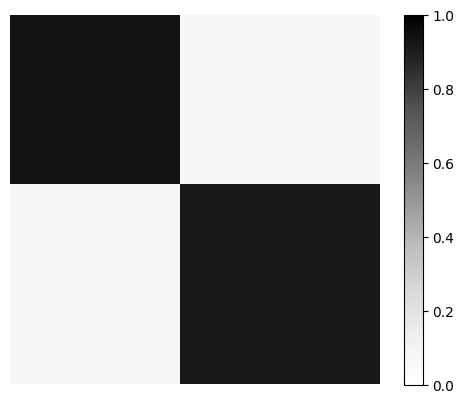

In [37]:
plt.figure()
plt.axis('off')
plt.imshow(w, vmin=0, vmax=1, cmap='Greys')
plt.colorbar()
plt.show()

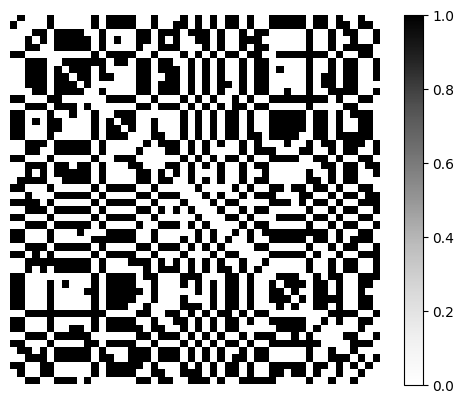

In [38]:
plt.figure()
plt.axis('off')
plt.imshow(adj_2, vmin=0, vmax=1, cmap='Greys')
plt.colorbar()
plt.show()

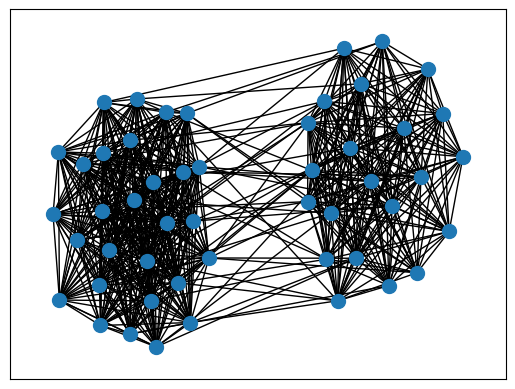

In [39]:
plt.figure()
g = nx.from_numpy_array(adj)
pos = nx.spring_layout(g)
nx.draw_networkx(g, pos=pos, with_labels=False, node_size=100)
plt.show()

# Gaussian noise model

In [55]:
def get_noise():
    n = adj_2.shape[0]
    w = np.random.randn(n, n)
    return (w + w.T) / np.sqrt(2)

In [97]:
def plot_forward_diffusion(adjacencies):
    _, ax = plt.subplots(len(adjacencies), 1, figsize=[6, 20])
    ax = ax.flatten()
    for i in range(len(adjacencies)):
        img = adjacencies[i]
        ax[i].imshow(img, cmap='gray')
        ax[i].axis('off')
    plt.show()

In [76]:
g = sample_sbm_graphon(
    res=100,
    max_groups=2,
    range_p_intra=[0.9, 0.95],
    range_p_inter=[0.05, 0.1],
    range_n_nodes=[10, 100]
)

adj = get_adj(50, g, sort=False)
alphas = np.arange(0.0, 1.0, 0.01)[::-1]  
adjacencies = [adj]
for alpha in alphas:
    w = get_noise()
    adj = adj * np.sqrt(alpha) + np.sqrt(1 - alpha) * w
    adjacencies.append(adj)

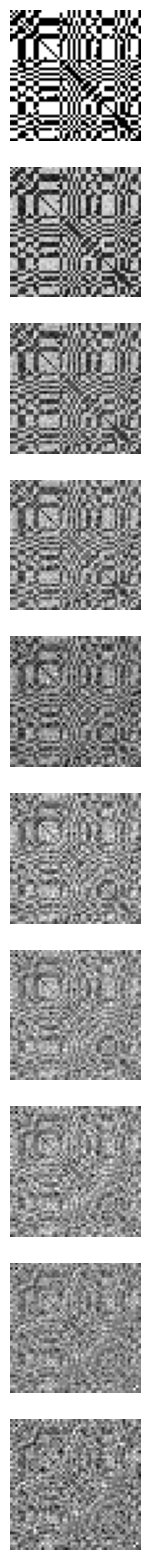

In [98]:
plot_forward_diffusion(adjacencies[:10])

# Gaussian graph-diffused noise model

In [ ]:
def get_noise():
    n = adj_2.shape[0]
    w = np.random.randn(n, n)
    return (w + w.T) / np.sqrt(2)

In [ ]:
def plot_forward_diffusion(adjacencies):
    _, ax = plt.subplots(len(adjacencies), 1, figsize=[6, 20])
    ax = ax.flatten()
    for i in range(len(adjacencies)):
        img = adjacencies[i]
        ax[i].imshow(img, cmap='gray')
        ax[i].axis('off')
    plt.show()

In [104]:
g = sample_sbm_graphon(
    res=100,
    max_groups=2,
    range_p_intra=[0.9, 0.95],
    range_p_inter=[0.05, 0.1],
    range_n_nodes=[10, 100]
)

adj = get_adj(50, g, sort=False)
alphas = np.arange(0.0, 1.0, 0.01)[::-1]  
adjacencies = [adj]
for alpha in alphas:
    w = get_noise()
    adj = (1 / np.linalg.eigvals(adj).max()) * adj @ adj * np.sqrt(alpha) + np.sqrt(1 - alpha) * w
    adjacencies.append(adj)

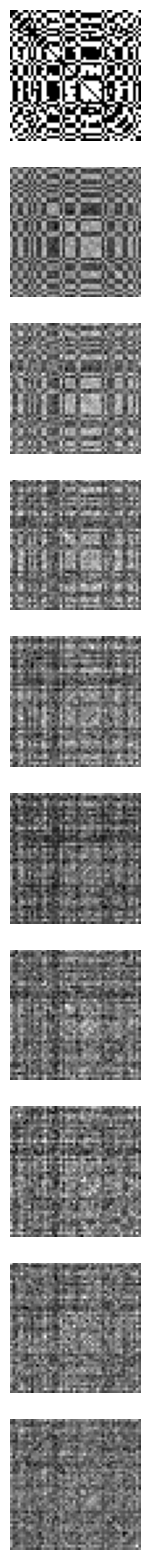

In [105]:
plot_forward_diffusion(adjacencies[:10])

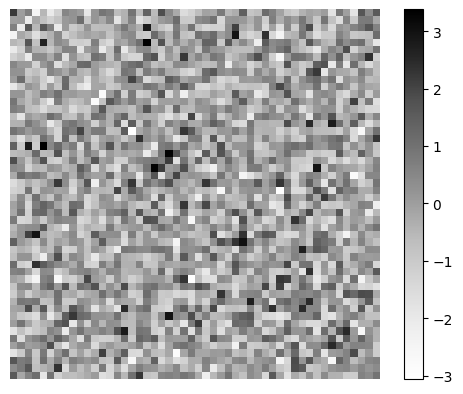

In [107]:
plt.figure()
plt.axis('off')
plt.imshow(adjacencies[-1], cmap='Greys')
plt.colorbar()
plt.show()